In [1]:
#import required classes and packages
import os
import cv2
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from face_detector import get_face_detector, find_faces
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from keras.utils.np_utils import to_categorical
from keras.layers import  MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D
from keras.models import Sequential, load_model, Model
import pickle
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout
from sklearn.tree import DecisionTreeClassifier
from keras.applications import VGG19
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import keras
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt   

Using TensorFlow backend.
c:\users\krish\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\krish\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\krish\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [2]:
#define and load class labels found in dataset
path = "Dataset"
labels = []
X = []
Y = []
for root, dirs, directory in os.walk(path):
    for j in range(len(directory)):
        name = os.path.basename(root)
        if name not in labels:
            labels.append(name.strip())   
print("Cricket Players Class Labels : "+str(labels))

Cricket Players Class Labels : ['babar_azam', 'bhuvneshwar_kumar', 'dinesh_karthik', 'hardik_pandya', 'jasprit_bumrah', 'kuldeep_yadav', 'ms_dhoni', 'ravindra_jadeja', 'rohit_sharma', 'shakib_al_hasan', 'shikhar_dhawan', 'shoaib_malik', 'vijay_shankar', 'virat_kohli']


In [3]:
#define function to get class label of given image
def getLabel(name):
    index = -1
    for i in range(len(labels)):
        if labels[i] == name:
            index = i
            break
    return index

In [4]:
#object to detect face
face_model = get_face_detector()

In [5]:
#load dataset image and process them
if os.path.exists("model/X.txt.npy"):
    X = np.load('model/X.txt.npy')
    Y = np.load('model/Y.txt.npy')
else: #if images not process then read and process image pixels
    for root, dirs, directory in os.walk(path):#connect to dataset folder
        for j in range(len(directory)):#loop all images from dataset folder
            name = os.path.basename(root)
            if 'Thumbs.db' not in directory[j]:
                img = cv2.imread(root+"/"+directory[j])#read images
                faces = find_faces(img, face_model)#function to detect face
                for x, y, x1, y1 in faces:
                    roi = img[y:y1, x:x1]#extract face features
                    roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)#convert color face to gray
                    if roi is not None:
                        roi = cv2.resize(roi, (32, 32))#resizing all faces to equal size
                        X.append(roi.ravel())#add features to X training array
                        label = getLabel(name)#get integer class label for given player
                        Y.append(label)                             
    X = np.asarray(X)#convert array as numpy array
    Y = np.asarray(Y)
    np.save('model/X.txt',X)#save process images and labels
    np.save('model/Y.txt',Y)
print("Dataset images loaded")
print("Total images found in dataset : "+str(X.shape[0]))
print()

Dataset images loaded
Total images found in dataset : 229



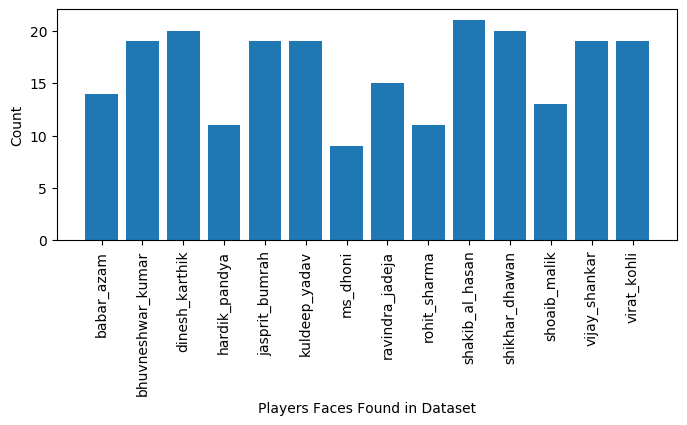

In [6]:
#visualizing class labels count found in dataset
names, count = np.unique(Y, return_counts = True)
height = count
bars = labels
y_pos = np.arange(len(bars))
plt.figure(figsize = (8, 3)) 
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.xlabel("Players Faces Found in Dataset")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

In [7]:
#apply preprocessing techniques such as shuffling and normalization
indices = np.arange(X.shape[0])
np.random.shuffle(indices)#shuffle images
X = X[indices]
Y = Y[indices]
#normalize all image faces pixel values
sc = StandardScaler()
X = sc.fit_transform(X)
print("Normalized Faces Features = "+str(X))

Normalized Faces Features = [[-0.78350705 -0.74176856 -0.79457324 ...  0.23330034  0.26117898
  -0.03963345]
 [-0.19911703 -0.62808131 -0.12032884 ... -1.34492284 -0.15834396
   0.01431044]
 [-0.81426442 -0.69304546 -0.6881136  ... -0.68732985 -1.01137393
  -1.18594108]
 ...
 [-0.81426442 -0.48191198 -0.95426271 ... -1.57873368 -1.65464243
  -1.29382886]
 [-1.06032338 -1.05034826 -1.0252358  ... -0.42429265  0.24719488
   0.37843169]
 [-0.92191522 -0.80673271 -0.49293759 ... -0.62887714 -0.80161246
  -0.740904  ]]


In [8]:
#applying LDA algorithm to extract features from processed faces
lda = LinearDiscriminantAnalysis(n_components=13)
X = lda.fit_transform(X, Y)
print("LDA Features Extraction Completed")

LDA Features Extraction Completed


In [9]:
#split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print("Dataset Train & Test Split Details")
print("80% images used to train algorithms : "+str(X_train.shape[0]))
print("20% image used to train algorithms : "+str(X_test.shape[0]))

Dataset Train & Test Split Details
80% images used to train algorithms : 183
20% image used to train algorithms : 46


In [10]:
#define global variables to save accuracy and other metrics
accuracy = []
precision = []
recall = []
fscore = []

In [11]:
def calculateMetrics(algorithm, predict, y_test):
    a = accuracy_score(y_test,predict)*100
    p = precision_score(y_test, predict,average='macro') * 100
    r = recall_score(y_test, predict,average='macro') * 100
    f = f1_score(y_test, predict,average='macro') * 100
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    print(algorithm+" Accuracy  :  "+str(a))
    print(algorithm+" Precision : "+str(p))
    print(algorithm+" Recall    : "+str(r))
    print(algorithm+" FScore    : "+str(f))    
    conf_matrix = confusion_matrix(y_test, predict) 
    plt.figure(figsize =(8, 5)) 
    ax = sns.heatmap(conf_matrix, xticklabels = labels, yticklabels = labels, annot = True, cmap="viridis" ,fmt ="g");
    ax.set_ylim([0,len(labels)])
    plt.title(algorithm+" Confusion matrix") 
    plt.xticks(rotation=90)
    plt.ylabel('True class') 
    plt.xlabel('Predicted class') 
    plt.show()    



Existing CNN Algorithm Accuracy  :  89.13043478260869
Existing CNN Algorithm Precision : 84.6938775510204
Existing CNN Algorithm Recall    : 86.30952380952381
Existing CNN Algorithm FScore    : 84.92364778079065


c:\users\krish\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


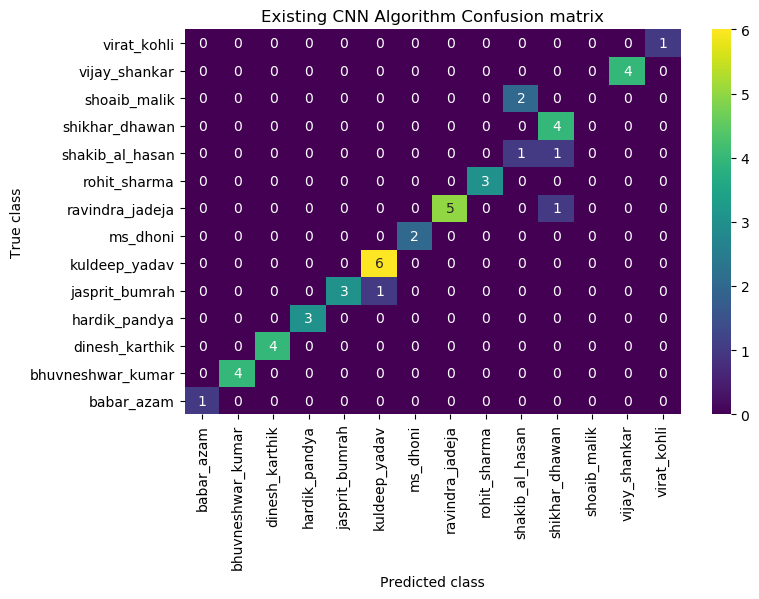

In [12]:
y_train1 = to_categorical(y_train)
y_test1 = to_categorical(y_test)
X_train1 = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1, 1))
X_test1 = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1, 1))
#train existing CNN algorithm
cnn_model = Sequential()
cnn_model.add(Convolution2D(32, (1 , 1), input_shape = (X_train1.shape[1], X_train1.shape[2], X_train1.shape[3]), activation = 'relu'))
cnn_model.add(MaxPooling2D(pool_size = (1, 1)))
cnn_model.add(Convolution2D(32, (1, 1), activation = 'relu'))
cnn_model.add(MaxPooling2D(pool_size = (1, 1)))
cnn_model.add(Flatten())
cnn_model.add(Dense(units = 256, activation = 'relu'))
cnn_model.add(Dense(units = y_train1.shape[1], activation = 'softmax'))
cnn_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
#compiling, training and loading model
if os.path.exists("model/cnn_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/cnn_weights.hdf5', verbose = 1, save_best_only = True)
    hist = cnn_model.fit(X_train1, y_train1, batch_size = 256, epochs = 10, validation_data=(X_test1, y_test1), callbacks=[model_check_point], verbose=1)
    f = open('model/cnn_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    cnn_model.load_weights("model/cnn_weights.hdf5")
#perform prediction on test data   
predict = cnn_model.predict(X_test1)
predict = np.argmax(predict, axis=1)
y_test2 = np.argmax(y_test1, axis=1)
calculateMetrics("Existing CNN Algorithm", predict, y_test2)#calculate accuracy and other metrics

Propose PAL AdaBoost Algorithm Accuracy  :  89.13043478260869
Propose PAL AdaBoost Algorithm Precision : 87.85714285714286
Propose PAL AdaBoost Algorithm Recall    : 89.28571428571429
Propose PAL AdaBoost Algorithm FScore    : 87.6046176046176


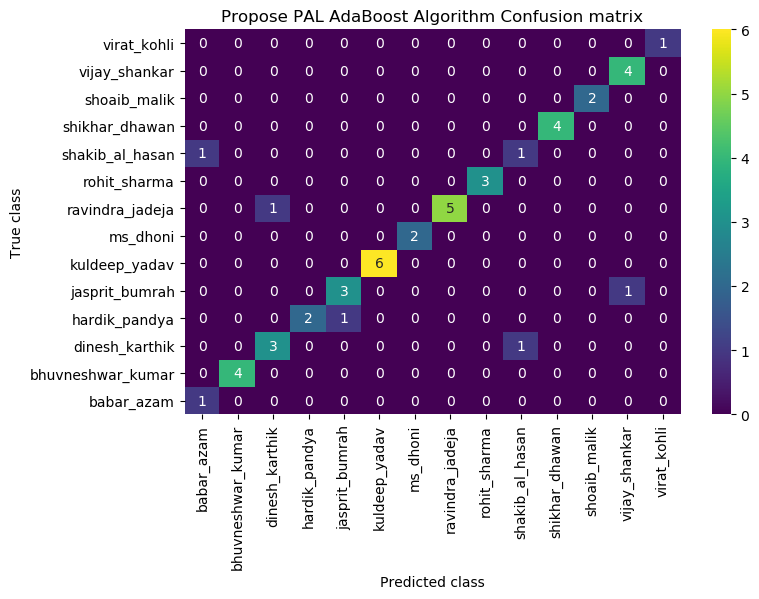

In [13]:
#train propose PAL algorithm using LDA features and AdaBoost algorithm
ada = AdaBoostClassifier(base_estimator=RandomForestClassifier(), n_estimators=200, learning_rate=0.5)
ada.fit(X_train, y_train)
#perform prediction on test data
predict = ada.predict(X_test)
calculateMetrics("Propose PAL AdaBoost Algorithm", predict, y_test)#calculate accuracy and other metrics

Extension Enhanced VGG19-CNN Algorithm Accuracy  :  93.47826086956522
Extension Enhanced VGG19-CNN Algorithm Precision : 93.57142857142858
Extension Enhanced VGG19-CNN Algorithm Recall    : 93.45238095238095
Extension Enhanced VGG19-CNN Algorithm FScore    : 91.98103483817769


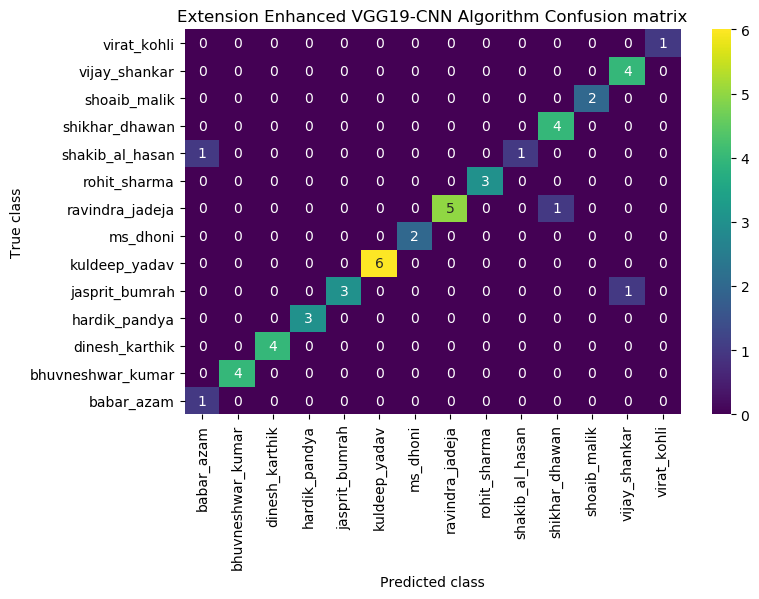

In [14]:
#training extension enhanced CNN model by using VGG19 petrained model
vgg_model = VGG19(input_shape=(32, 32, 3), include_top=False, weights=None)
for layer in vgg_model.layers:
    layer.trainable = False
vgg_model = Sequential()
vgg_model.add(Convolution2D(32, (1 , 1), input_shape = (X_train1.shape[1], X_train1.shape[2], X_train1.shape[3]), activation = 'relu'))
vgg_model.add(MaxPooling2D(pool_size = (1, 1)))
vgg_model.add(Dropout(0.2))
vgg_model.add(Convolution2D(32, (1, 1), activation = 'relu'))
vgg_model.add(MaxPooling2D(pool_size = (1, 1)))
vgg_model.add(Dropout(0.2))
vgg_model.add(Flatten())
vgg_model.add(Dense(units = 256, activation = 'relu'))
vgg_model.add(Dense(units = y_train1.shape[1], activation = 'softmax'))
#compiling, training and loading model
vgg_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/extension_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/extension_weights.hdf5', verbose = 1, save_best_only = True)
    hist = vgg_model.fit(X_train1, y_train1, batch_size = 16, epochs = 10, validation_data=(X_test1, y_test1), callbacks=[model_check_point], verbose=1)
    f = open('model/extension_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    vgg_model.load_weights("model/extension_weights.hdf5")
#perform prediction on test data
predict = vgg_model.predict(X_test1)
predict = np.argmax(predict, axis=1)
y_test2 = np.argmax(y_test1, axis=1)
calculateMetrics("Extension Enhanced VGG19-CNN Algorithm", predict, y_test2)#calculate accuracy and other metrics

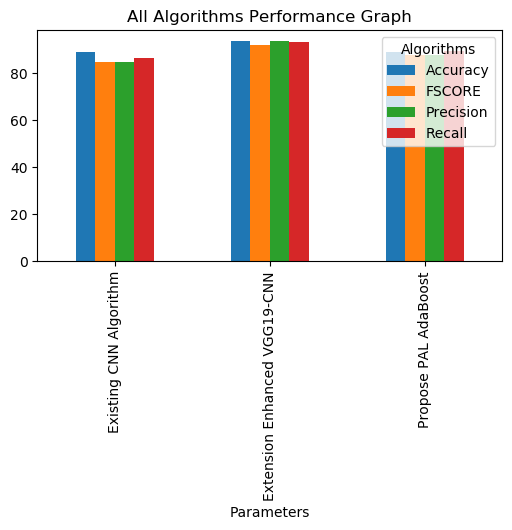

In [15]:
#plot all algorithm performance in tabukar format
import pandas as pd
df = pd.DataFrame([['Existing CNN Algorithm','Accuracy',accuracy[0]],['Existing CNN Algorithm','Precision',precision[0]],['Existing CNN Algorithm','Recall',recall[0]],['Existing CNN Algorithm','FSCORE',fscore[0]],
                   ['Propose PAL AdaBoost','Accuracy',accuracy[1]],['Propose PAL AdaBoost','Precision',precision[1]],['Propose PAL AdaBoost','Recall',recall[1]],['Propose PAL AdaBoost','FSCORE',fscore[1]],
                   ['Extension Enhanced VGG19-CNN','Accuracy',accuracy[2]],['Extension Enhanced VGG19-CNN','Precision',precision[2]],['Extension Enhanced VGG19-CNN','Recall',recall[2]],['Extension Enhanced VGG19-CNN','FSCORE',fscore[2]],
                  ],columns=['Parameters','Algorithms','Value'])
df.pivot("Parameters", "Algorithms", "Value").plot(kind='bar', figsize=(6, 3))
plt.title("All Algorithms Performance Graph")
plt.show()

In [16]:
#display all algorithm performnace
algorithms = ['Existing CNN Algorithm', 'Propose PAL AdaBoost', 'Extension Enhanced VGG19-CNN Model']
data = []
for i in range(len(accuracy)):
    data.append([algorithms[i], accuracy[i], precision[i], recall[i], fscore[i]])
data = pd.DataFrame(data, columns=['Algorithm Name', 'Accuracy', 'Precision', 'Recall', 'FSCORE'])
data  

,Algorithm Name,Accuracy,Precision,Recall,FSCORE
0,Existing CNN Algorithm,89.130435,84.693878,86.309524,84.923648
1,Propose PAL AdaBoost,89.130435,87.857143,89.285714,87.604618
2,Extension Enhanced VGG19-CNN Model,93.478261,93.571429,93.452381,91.981035


In [17]:
#function to perfrom prediction on test image
#use this function to predict fish species uisng extension model
def predict(image_path):
    image = cv2.imread(image_path)#read test image
    faces = find_faces(image, face_model)
    for x, y, x1, y1 in faces:
        roi = image[y:y1, x:x1]#extract face from image
        roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        if roi is not None: #if face roi is not none then resize image
            roi = cv2.resize(roi, (32, 32))
            cv2.rectangle(image, (x, y), (x1, y1), (255, 0, 0), 2)
            temp = []
            temp.append(roi.ravel())
            temp = np.asarray(temp)
            temp = sc.transform(temp)#normalize imagee features using mean
            temp = lda.transform(temp)#extract features using lda
            temp = np.reshape(temp, (temp.shape[0], temp.shape[1], 1, 1))
            predict = vgg_model.predict(temp)#now predict player name
            predict = np.argmax(predict)
            print(labels[predict])
            cv2.putText(image, labels[predict], (x, y1+20),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (255, 0, 0), 2)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)        
    plt.imshow(image)        

dinesh_karthik


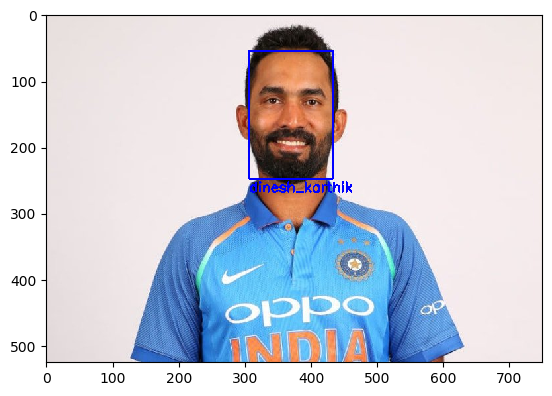

In [18]:
#call this function with test image to predict player name
predict("testImages/0.jpg")

dinesh_karthik


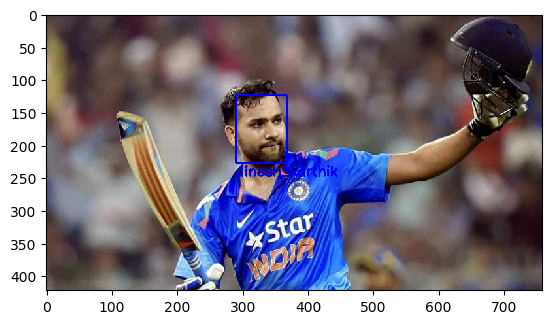

In [19]:
#call this function with test image to predict player name
predict("testImages/1.jpg")

babar_azam


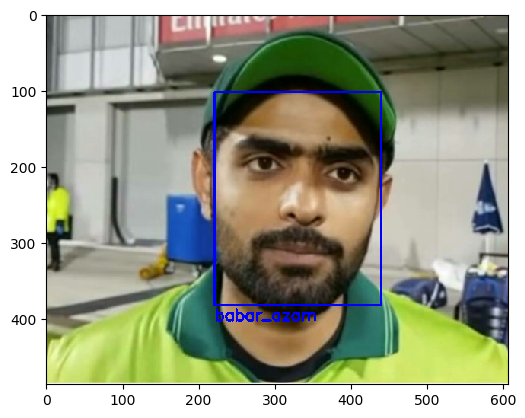

In [20]:
#call this function with test image to predict player name
predict("testImages/2.jpg")

rohit_sharma
bhuvneshwar_kumar


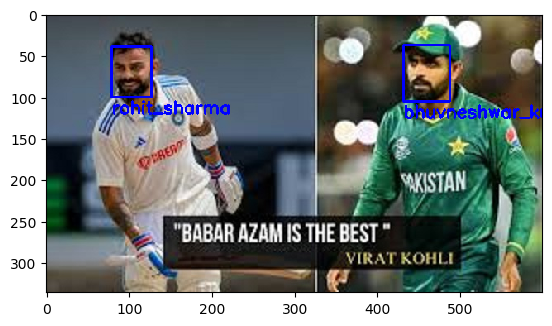

In [21]:
#call this function with test image to predict player name
predict("testImages/10.jpg")

ravindra_jadeja


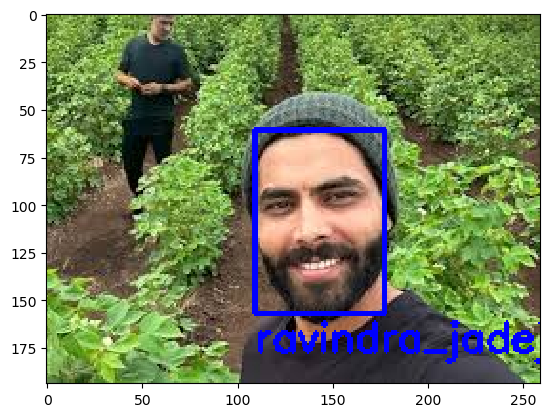

In [22]:
#call this function with test image to predict player name
predict("testImages/12.jpg")

In [23]:
#=================flask code starts here
from flask import Flask, render_template, request, redirect, url_for, session,send_from_directory
import base64
import io

In [24]:
app = Flask(__name__)
app.secret_key = 'welcome'

In [25]:
def getModel():
    #training extension enhanced CNN model by using VGG19 petrained model
    vgg_model = VGG19(input_shape=(32, 32, 3), include_top=False, weights=None)
    for layer in vgg_model.layers:
        layer.trainable = False
    vgg_model = Sequential()
    vgg_model.add(Convolution2D(32, (1 , 1), input_shape = (X_train1.shape[1], X_train1.shape[2], X_train1.shape[3]), activation = 'relu'))
    vgg_model.add(MaxPooling2D(pool_size = (1, 1)))
    vgg_model.add(Dropout(0.2))
    vgg_model.add(Convolution2D(32, (1, 1), activation = 'relu'))
    vgg_model.add(MaxPooling2D(pool_size = (1, 1)))
    vgg_model.add(Dropout(0.2))
    vgg_model.add(Flatten())
    vgg_model.add(Dense(units = 256, activation = 'relu'))
    vgg_model.add(Dense(units = y_train1.shape[1], activation = 'softmax'))
    #compiling, training and loading model
    vgg_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    if os.path.exists("model/extension_weights.hdf5") == False:
        model_check_point = ModelCheckpoint(filepath='model/extension_weights.hdf5', verbose = 1, save_best_only = True)
        hist = vgg_model.fit(X_train1, y_train1, batch_size = 16, epochs = 10, validation_data=(X_test1, y_test1), callbacks=[model_check_point], verbose=1)
        f = open('model/extension_history.pckl', 'wb')
        pickle.dump(hist.history, f)
        f.close()    
    else:
        vgg_model.load_weights("model/extension_weights.hdf5")
    return vgg_model    

In [26]:
@app.route('/Predict', methods=['GET', 'POST'])
def predictView():
    return render_template('Predict.html', msg='')

@app.route('/index', methods=['GET', 'POST'])
def index():
    return render_template('index.html', msg='')

@app.route('/AdminLogin', methods=['GET', 'POST'])
def AdminLogin():
    return render_template('AdminLogin.html', msg='')

@app.route('/AdminLoginAction', methods=['GET', 'POST'])
def AdminLoginAction():
    if request.method == 'POST' and 't1' in request.form and 't2' in request.form:
        user = request.form['t1']
        password = request.form['t2']
        if user == "admin" and password == "admin":
            return render_template('AdminScreen.html', msg="Welcome "+user)
        else:
            return render_template('AdminLogin.html', msg="Invalid login details")

@app.route('/Logout')
def Logout():
    return render_template('index.html', msg='')

@app.route('/PredictAction', methods=['GET', 'POST'])
def PredictAction():   
    if request.method == 'POST':
        file = request.files['t1']
        img_bytes = file.read()
        if os.path.exists("static/test.jpg"):
            os.remove("static/test.jpg")
        with open('static/test.jpg', mode="wb") as jpg:
            jpg.write(img_bytes)
        jpg.close()
        vgg_model = getModel()
        image = cv2.imread('static/test.jpg')#read test image
        faces = find_faces(image, face_model)
        output = ""
        for x, y, x1, y1 in faces:
            roi = image[y:y1, x:x1]#extract face from image
            roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
            if roi is not None: #if face roi is not none then resize image
                roi = cv2.resize(roi, (32, 32))
                cv2.rectangle(image, (x, y), (x1, y1), (255, 0, 0), 2)
                temp = []
                temp.append(roi.ravel())
                temp = np.asarray(temp)
                temp = sc.transform(temp)#normalize imagee features using mean
                temp = lda.transform(temp)#extract features using lda
                temp = np.reshape(temp, (temp.shape[0], temp.shape[1], 1, 1))
                predict = vgg_model.predict(temp)#now predict player name
                predict = np.argmax(predict)
                output += labels[predict]+"</br>"
                cv2.putText(image, labels[predict], (x, y1+20),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (255, 0, 0), 2)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)        
        plt.imshow(image) 
        buf = io.BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight')
        plt.close()
        img_b64 = base64.b64encode(buf.getvalue()).decode() 
        return render_template('AdminScreen.html', msg=output, img = img_b64)

In [ ]:
if __name__ == '__main__':
    app.run()

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [23/May/2025 07:04:06] "GET /index HTTP/1.1" 200 -
127.0.0.1 - - [23/May/2025 07:04:07] "GET /static/images/tra.jpg HTTP/1.1" 304 -
127.0.0.1 - - [23/May/2025 07:04:07] "GET /static/default.css HTTP/1.1" 200 -
127.0.0.1 - - [23/May/2025 07:04:07] "GET /static/images/back.jpg HTTP/1.1" 304 -
127.0.0.1 - - [23/May/2025 07:04:07] "GET /static/images/img05.jpg HTTP/1.1" 200 -
127.0.0.1 - - [23/May/2025 07:04:07] "GET /static/images/bg.jpg HTTP/1.1" 200 -
127.0.0.1 - - [23/May/2025 07:04:07] "GET /static/images/img02.jpg HTTP/1.1" 200 -
127.0.0.1 - - [23/May/2025 07:04:07] "GET /static/images/img03.jpg HTTP/1.1" 200 -
127.0.0.1 - - [23/May/2025 07:04:07] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [23/May/2025 07:04:09] "GET /AdminLogin HTTP/1.1" 200 -
127.0.0.1 - - [23/May/2025 07:04:09] "GET /static/default.css HTTP/1.1" 304 -
127.0.0.1 - - [23/May/2025 07:04:09] "GET /static/images/tra.jpg HTTP/1.1" 304 -
127.0.0.